In [1]:
import os
import subprocess
import sys
import numpy as np
from typing import Optional
from matplotlib import pyplot as plt

sys.path.append("..")
from Experiment import Experiment
from utils.experiment_utils import get_fe_trajs

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Enhanced Sampling Experiments with Learnt CVs

**Systems**: Alanine dipeptide, chignolin. <br>
**CV algorithms**: PCA, tICA, VAMP. <br>
**Baseline comparison**: Literature dihedral angle CVs. <br>
**Enhanced sampling method**: Well-tempered metadynamics. <br>
**Enhanced sampling parameters**: gaussian_height - 1.2, gaussian_pace - every 1ps, bias_factor - 8, sigma - 0.35 (same for every CV). <br>
**Simulation details**: duration - 50ns, stepsize - 2fs, frictioncoeff - 1ps^-1, water - tip3p, precision - mixed, temperature - 300K, nonbondedcutoff - 0.8nm, solventpadding - 1nm, cutoffmethod - CutoffPeriodic, forcefield - amber14, ensemble - NVT. <br>


## About PLUMED Implementation

To implement enhanced sampling correctly in PLUMED raises some challenges. <br>
In particular:
- One has to pay attention to the periodicity of the CVs
- In practice, enhanced sampling along non-ideal CVs seems to make the simulation brittle and ofter run into NaN errors

These issues are highlighted as the crop up in the context of specific simulations below.

To illustrate how brittle these runs can be, all of the following failed after several minutes of simulation:
**ADD**

# Experiment: Alanine Dipeptide

### Baseline FES
153.7ns with $\phi$ and $\psi$ backbone angles as the CVs <br>
NB: No reweighting required since CVs coincide with dimensions of FES. <br>

*PLUMED SCRIPT*
```
RESTART
TORSION ATOMS=5,7,9,15 LABEL=5_7_9_15 
TORSION ATOMS=7,9,15,17 LABEL=7_9_15_17 
CUSTOM ARG=5_7_9_15 FUNC=(x)-0.0 LABEL=DIH_5_7_9_15 PERIODIC=-3.141592653589793,3.141592653589793 
CUSTOM ARG=7_9_15_17 FUNC=(x)-0.0 LABEL=DIH_7_9_15_17 PERIODIC=-3.141592653589793,3.141592653589793 
METAD ARG=DIH_5_7_9_15,DIH_7_9_15_17 SIGMA=0.35,0.35 HEIGHT=1.2 BIASFACTOR=8 TEMP=300 FILE=HILLS PACE=500 LABEL=metad 
PRINT ARG=DIH_5_7_9_15,DIH_7_9_15_17,metad.bias STRIDE=500 FILE=COLVAR
```

Successfully initialised metadata.
3 PDB files found in the given directory:
[1] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/DIH:_ACE_1_C_4_0_-_ALA_2_N_6_0_-_ALA_2_CA_8_0_-_ALA_2_C_14_0__DIH:_ALA_2_N_6_0_-_ALA_2_CA_8_0_-_ALA_2_C_14_0_-_NME_3_N_16_0__structure0_repeat_0_total_features_4_feature_dimensions_None/minimised.pdb
[2] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/DIH:_ACE_1_C_4_0_-_ALA_2_N_6_0_-_ALA_2_CA_8_0_-_ALA_2_C_14_0__DIH:_ALA_2_N_6_0_-_ALA_2_CA_8_0_-_ALA_2_C_14_0_-_NME_3_N_16_0__structure0_repeat_0_total_features_4_feature_dimensions_None/top.pdb
[3] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/DIH:_ACE_1_C_4_0_-_ALA_2_N_6_0_-_ALA_2_CA_8_0_-_ALA_2_C_14_0__DIH:_ALA_2_N_6_0_-_ALA_2_CA_8_0_-_ALA_2_C_14_0_-_NME_3_N_16_0__structure0_repeat_0_total_features_4_feature_dimensions_None/top_no_water.pdb
[Notice] No features provided; trajectory de

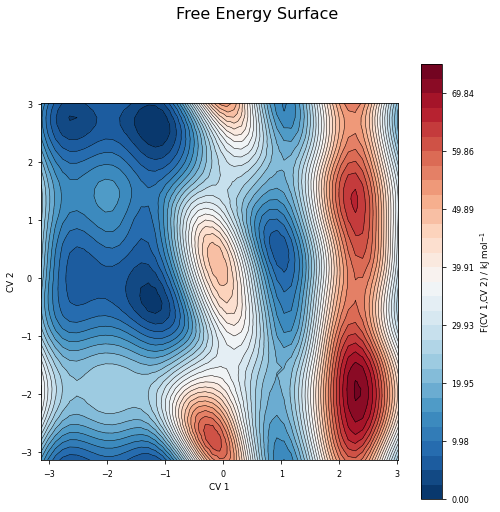

(<Figure size 576x576 with 2 Axes>, <AxesSubplot:xlabel='CV 1', ylabel='CV 2'>)

In [2]:
exp = Experiment('/home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/DIH:_ACE_1_C_4_0_-_ALA_2_N_6_0_-_ALA_2_CA_8_0_-_ALA_2_C_14_0__DIH:_ALA_2_N_6_0_-_ALA_2_CA_8_0_-_ALA_2_C_14_0_-_NME_3_N_16_0__structure0_repeat_0_total_features_4_feature_dimensions_None');
exp.free_energy_plot(fig_size=(8,8))

### PCA Enhanced Sampling


### 4 backbone dihedrals with sin/cos [50ns]

Successfully initialised metadata.
[Notice] No features provided; trajectory defined with cartesian coordinates (not recommended).
FES already calculated


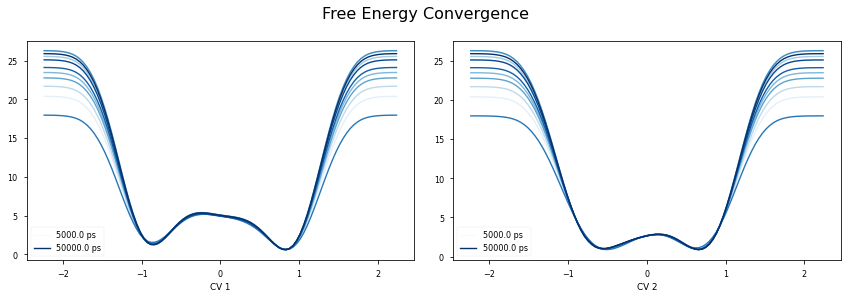

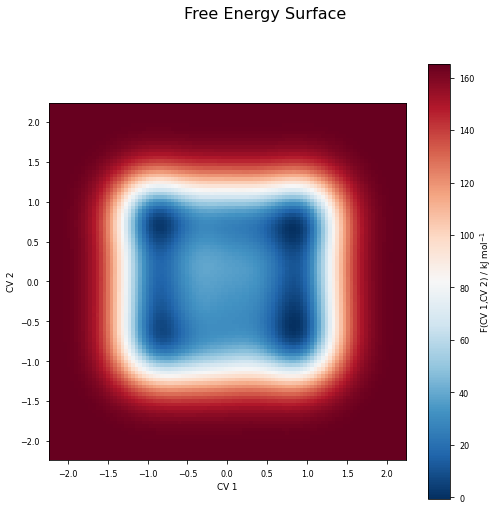

Segmentation fault (core dumped)
/home/dominic/miniconda3/envs/diffusion/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1176: UserWarning: ier=3199
  warnings.warn(message)


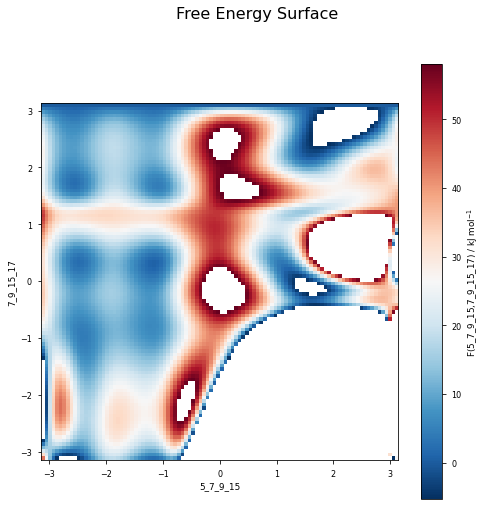

(<Figure size 576x576 with 2 Axes>,
 <AxesSubplot:xlabel='5_7_9_15', ylabel='7_9_15_17'>)

In [2]:
exp = Experiment('/home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/PCA:0_PCA:1_structure0_repeat_0_total_features_8_feature_dimensions_2')
exp.plot_fes_convergence(num_lines=10)
exp.free_energy_plot(fig_size=(8,8), plot_type='heatmap')
exp.free_energy_plot(reweight=True, fig_size=(8,8), features=["5_7_9_15", "7_9_15_17"])

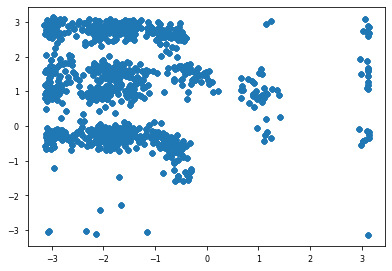

In [12]:
data = np.genfromtxt("/home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/PCA:0_PCA:1_structure0_repeat_0_total_features_8_feature_dimensions_2/COLVAR_REWEIGHT", autostrip=True)
fe_traj = get_fe_trajs(data, reweight=True, file_type='COLVAR')
plt.scatter(fe_traj[0], fe_traj[1])

### 100 backbone dihedrals with sin/cos [50ns]

Successfully initialised metadata.
3 PDB files found in the given directory:
[1] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/PCA:0_PCA:1_structure0_repeat_0_total_features_200_feature_dimensions_4/trajectory_processed.pdb
[2] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/PCA:0_PCA:1_structure0_repeat_0_total_features_200_feature_dimensions_4/top.pdb
[3] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/PCA:0_PCA:1_structure0_repeat_0_total_features_200_feature_dimensions_4/top_no_water.pdb
2 traj files found in the given directory:
[1] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/PCA:0_PCA:1_structure0_repeat_0_total_features_200_feature_dimensions_4/trajectory.dcd
[2] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/PCA:0_PCA:1_structure0_repeat_0_total_features_200_featur

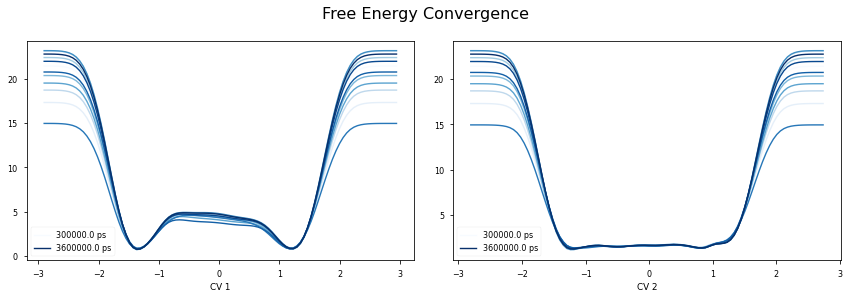

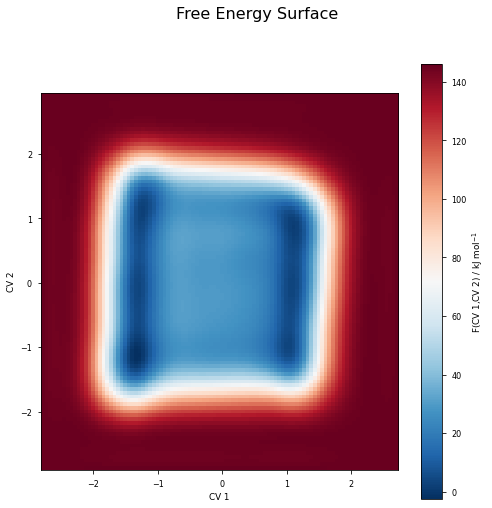

/home/dominic/miniconda3/envs/diffusion/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1176: UserWarning: ier=46276
  warnings.warn(message)


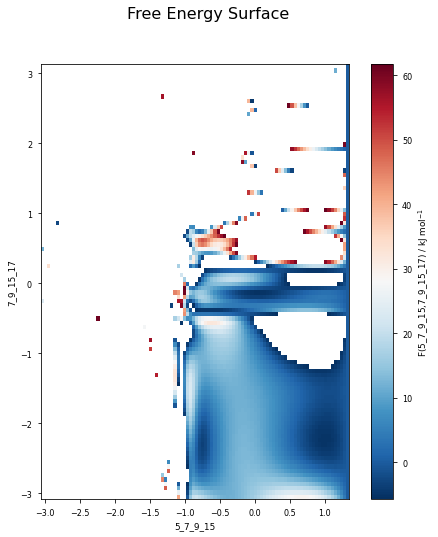

(<Figure size 576x576 with 2 Axes>,
 <AxesSubplot:xlabel='5_7_9_15', ylabel='7_9_15_17'>)

In [2]:
exp = Experiment('/home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/PCA:0_PCA:1_structure0_repeat_0_total_features_200_feature_dimensions_4')
exp.plot_fes_convergence(stride=6000)
exp.free_energy_plot(fig_size=(8,8))
exp.free_energy_plot(reweight=True, fig_size=(8,8), features=["5_7_9_15", "7_9_15_17"])

## TICA Enhanced Sampling

### 4 backbone features with sin/cos [50ns]

Successfully initialised metadata.
3 PDB files found in the given directory:
[1] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/TICA:0_TICA:1_structure0_repeat_0_total_features_8_feature_dimensions_2/trajectory_processed.pdb
[2] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/TICA:0_TICA:1_structure0_repeat_0_total_features_8_feature_dimensions_2/top.pdb
[3] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/TICA:0_TICA:1_structure0_repeat_0_total_features_8_feature_dimensions_2/top_no_water.pdb
2 traj files found in the given directory:
[1] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/TICA:0_TICA:1_structure0_repeat_0_total_features_8_feature_dimensions_2/trajectory.dcd
[2] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/TICA:0_TICA:1_structure0_repeat_0_total_features_8_featur

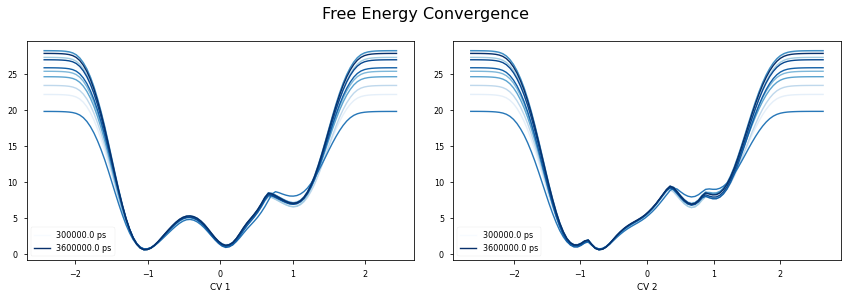

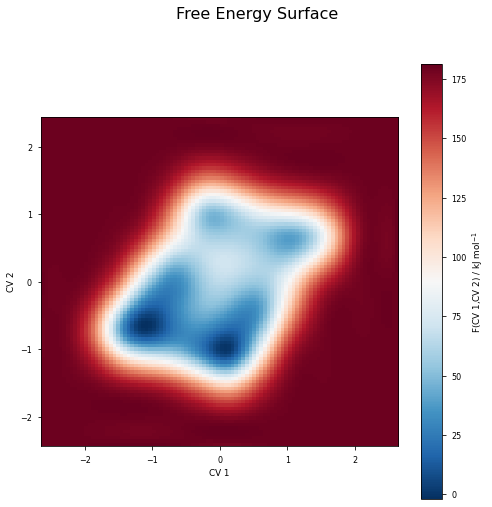

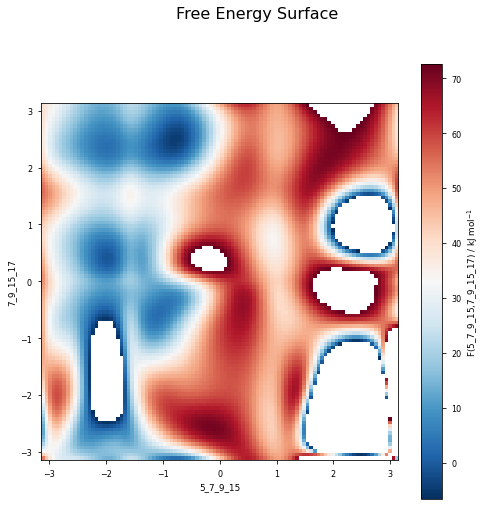

(<Figure size 576x576 with 2 Axes>,
 <AxesSubplot:xlabel='5_7_9_15', ylabel='7_9_15_17'>)

In [3]:
exp = Experiment('/home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/TICA:0_TICA:1_structure0_repeat_0_total_features_8_feature_dimensions_2')
exp.plot_fes_convergence(stride=6000)
exp.free_energy_plot(fig_size=(8,8))
exp.free_energy_plot(reweight=True, fig_size=(8,8), features=["5_7_9_15", "7_9_15_17"])

### 100 backbone features with sin/cos [50ns]

Successfully initialised metadata.
3 PDB files found in the given directory:
[1] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/TICA:0_TICA:1_structure0_repeat_0_total_features_200_feature_dimensions_4/trajectory_processed.pdb
[2] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/TICA:0_TICA:1_structure0_repeat_0_total_features_200_feature_dimensions_4/top.pdb
[3] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/TICA:0_TICA:1_structure0_repeat_0_total_features_200_feature_dimensions_4/top_no_water.pdb
2 traj files found in the given directory:
[1] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/TICA:0_TICA:1_structure0_repeat_0_total_features_200_feature_dimensions_4/trajectory.dcd
[2] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/TICA:0_TICA:1_structure0_repeat_0_total_features_

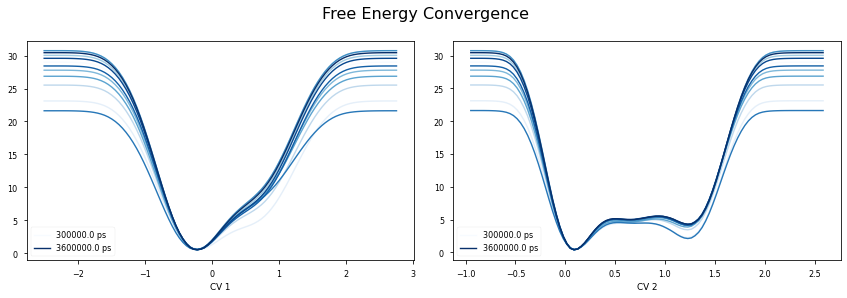

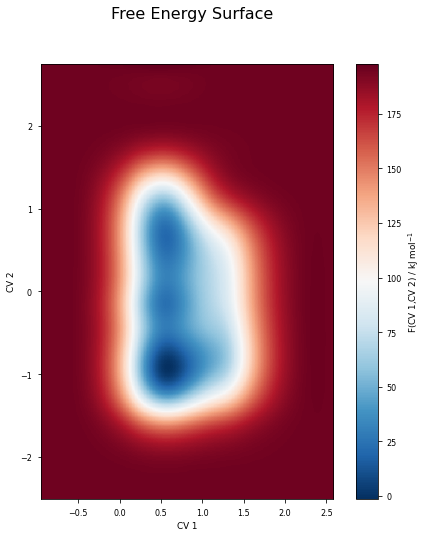

/home/dominic/miniconda3/envs/diffusion/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1176: UserWarning: ier=3884
  warnings.warn(message)


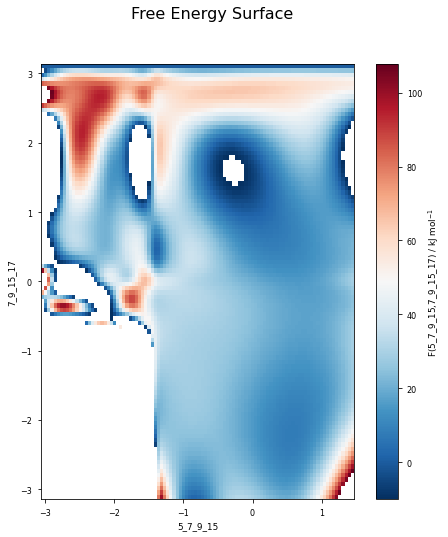

(<Figure size 576x576 with 2 Axes>,
 <AxesSubplot:xlabel='5_7_9_15', ylabel='7_9_15_17'>)

In [5]:
exp = Experiment('/home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/TICA:0_TICA:1_structure0_repeat_0_total_features_200_feature_dimensions_4')
exp.plot_fes_convergence(stride=6000)
exp.free_energy_plot(fig_size=(8,8))
exp.free_energy_plot(reweight=True, fig_size=(8,8), features=["5_7_9_15", "7_9_15_17"])

### VAMP Enhanced Sampling

 ### 4 backbone features with sin/cos [50ns]

Successfully initialised metadata.
3 PDB files found in the given directory:
[1] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/VAMP:0_VAMP:1_structure0_repeat_0_total_features_8_feature_dimensions_2/trajectory_processed.pdb
[2] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/VAMP:0_VAMP:1_structure0_repeat_0_total_features_8_feature_dimensions_2/top.pdb
[3] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/VAMP:0_VAMP:1_structure0_repeat_0_total_features_8_feature_dimensions_2/top_no_water.pdb
2 traj files found in the given directory:
[1] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/VAMP:0_VAMP:1_structure0_repeat_0_total_features_8_feature_dimensions_2/trajectory.dcd
[2] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/VAMP:0_VAMP:1_structure0_repeat_0_total_features_8_featur

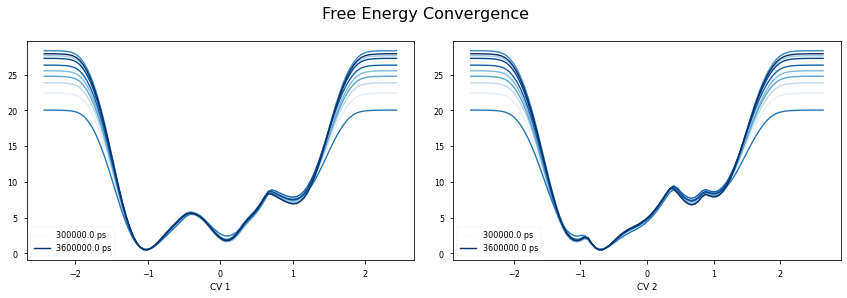

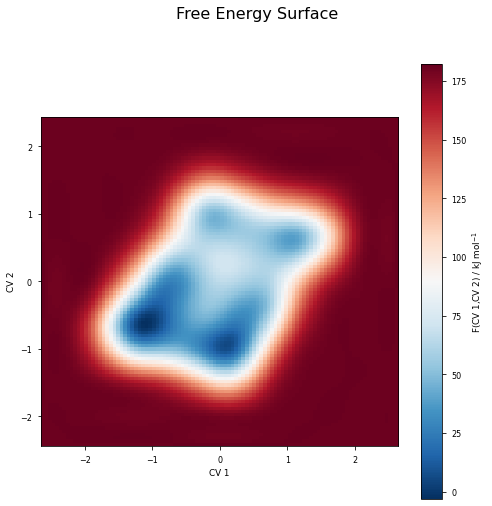

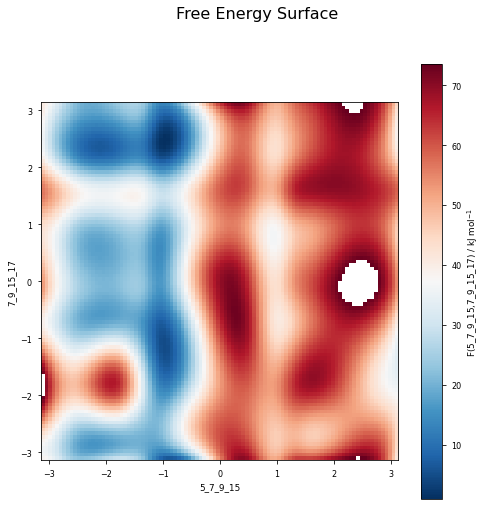

(<Figure size 576x576 with 2 Axes>,
 <AxesSubplot:xlabel='5_7_9_15', ylabel='7_9_15_17'>)

In [6]:
exp = Experiment("/home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/VAMP:0_VAMP:1_structure0_repeat_0_total_features_8_feature_dimensions_2")
exp.plot_fes_convergence(stride=6000)
exp.free_energy_plot(fig_size=(8,8))
exp.free_energy_plot(reweight=True, fig_size=(8,8), features=["5_7_9_15", "7_9_15_17"])

### 100 backbone features with sin/cos [50ns]

Successfully initialised metadata.
3 PDB files found in the given directory:
[1] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/VAMP:0_VAMP:1_structure0_repeat_0_total_features_200_feature_dimensions_4/trajectory_processed.pdb
[2] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/VAMP:0_VAMP:1_structure0_repeat_0_total_features_200_feature_dimensions_4/top.pdb
[3] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/VAMP:0_VAMP:1_structure0_repeat_0_total_features_200_feature_dimensions_4/top_no_water.pdb
2 traj files found in the given directory:
[1] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/VAMP:0_VAMP:1_structure0_repeat_0_total_features_200_feature_dimensions_4/trajectory.dcd
[2] /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/VAMP:0_VAMP:1_structure0_repeat_0_total_features_

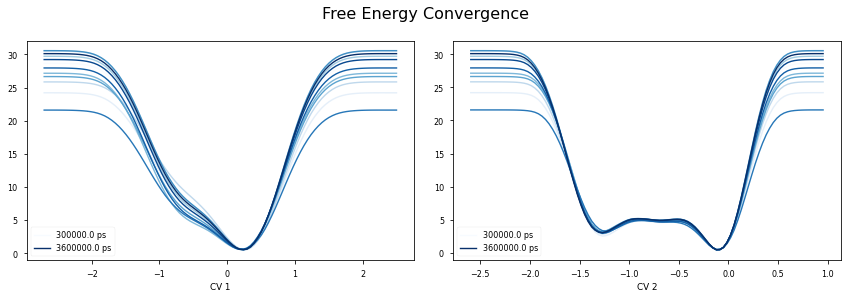

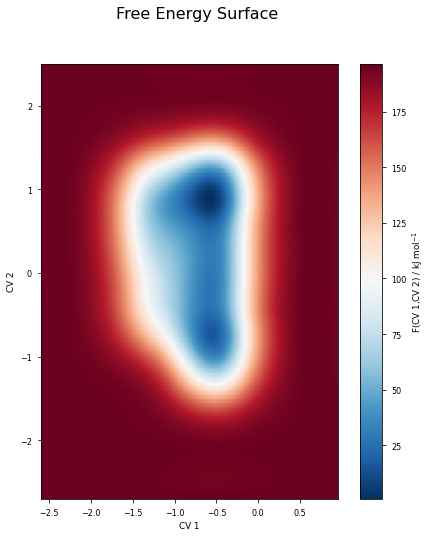

/home/dominic/miniconda3/envs/diffusion/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1176: UserWarning: ier=2911
  warnings.warn(message)


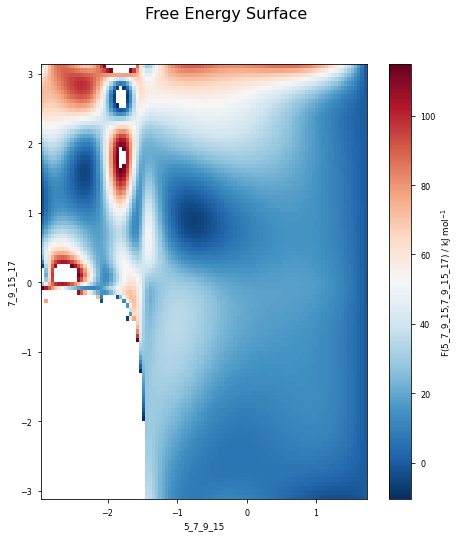

(<Figure size 576x576 with 2 Axes>,
 <AxesSubplot:xlabel='5_7_9_15', ylabel='7_9_15_17'>)

In [7]:
exp = Experiment("/home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/VAMP:0_VAMP:1_structure0_repeat_0_total_features_200_feature_dimensions_4")
exp.plot_fes_convergence(stride=6000)
exp.free_energy_plot(fig_size=(8,8))
exp.free_energy_plot(reweight=True, fig_size=(8,8), features=["5_7_9_15", "7_9_15_17"])

## Chignolin

In [1]:
from Experiment import Experiment


ModuleNotFoundError: No module named 'Experiment'

PLUMED: PLUMED is starting
PLUMED: Version: 2.8.1 (git: Unknown) compiled on Oct 21 2022 at 17:04:43
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finished se

(array([-5.41192   , -5.28856732, -5.16521465, ...,  3.09941465,
         3.22276732,  3.34612   ]),
 array([-3.97203, -3.97203, -3.97203, ...,  4.78602,  4.78602,  4.78602]),
 array([148.82706677, 148.82706677, 148.82706677, ..., 148.82706677,
        148.82706677, 148.82706677]))

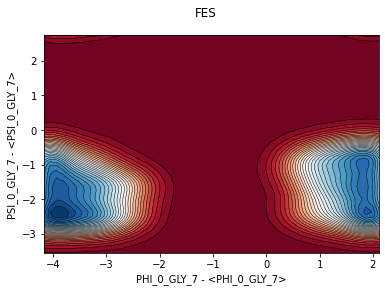

In [6]:
process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/chignolin/enhanced_sampling/PHI_0_GLY_7_PSI_0_GLY_7_structure14_repeat_0', xlabel='PHI_0_GLY_7 - <PHI_0_GLY_7>', ylabel='PSI_0_GLY_7 - <PSI_0_GLY_7>', xcorrection=-1.0328998565673828, ycorrection=-0.4069909453392029)

PLUMED: PLUMED is starting
PLUMED: Version: 2.8.1 (git: Unknown) compiled on Oct 21 2022 at 17:04:43
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finished se

(array([-5.41193   , -5.28857704, -5.16522409, ...,  3.09942408,
         3.22277704,  3.34613   ]),
 array([-3.97203, -3.97203, -3.97203, ...,  4.78602,  4.78602,  4.78602]),
 array([144.81299653, 144.81299653, 144.81299653, ..., 144.81299653,
        144.81299653, 144.81299653]))

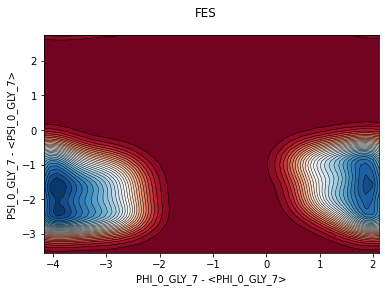

In [7]:
process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/chignolin/enhanced_sampling/PHI_0_GLY_7_PSI_0_GLY_7_structure17_repeat_0', xlabel='PHI_0_GLY_7 - <PHI_0_GLY_7>', ylabel='PSI_0_GLY_7 - <PSI_0_GLY_7>', xcorrection=-1.0328998565673828, ycorrection=-0.4069909453392029)

PLUMED: PLUMED is starting
PLUMED: Version: 2.8.1 (git: Unknown) compiled on Oct 21 2022 at 17:04:43
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finished se

(array([-5.41193   , -5.28857704, -5.16522409, ...,  3.09942408,
         3.22277704,  3.34613   ]),
 array([-3.97201, -3.97201, -3.97201, ...,  4.786  ,  4.786  ,  4.786  ]),
 array([146.52718714, 146.52718714, 146.52718714, ..., 146.52718714,
        146.52718714, 146.52718714]))

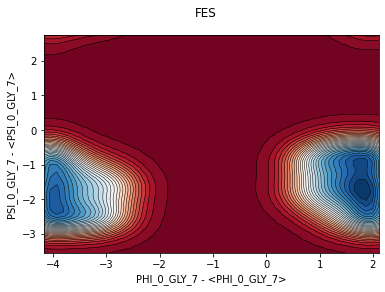

In [8]:
process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/chignolin/enhanced_sampling/PHI_0_GLY_7_PSI_0_GLY_7_structure18_repeat_0', xlabel='PHI_0_GLY_7 - <PHI_0_GLY_7>', ylabel='PSI_0_GLY_7 - <PSI_0_GLY_7>', xcorrection=-1.0328998565673828, ycorrection=-0.4069909453392029)


## Some incomplete runs

49% complete

PLUMED: PLUMED is starting
PLUMED: Version: 2.8.1 (git: Unknown) compiled on Oct 21 2022 at 17:04:43
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finished se

(array([-5.41192   , -5.28856761, -5.16521521, ...,  3.09939521,
         3.22274761,  3.3461    ]),
 array([-3.97204, -3.97204, -3.97204, ...,  4.78601,  4.78601,  4.78601]),
 array([125.01980706, 125.01980706, 125.01980706, ..., 125.01980706,
        125.01980706, 125.01980706]))

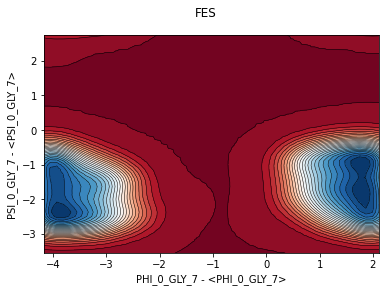

In [9]:
process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/chignolin/enhanced_sampling/PHI_0_GLY_7_PSI_0_GLY_7_structure19_repeat_0', xlabel='PHI_0_GLY_7 - <PHI_0_GLY_7>', ylabel='PSI_0_GLY_7 - <PSI_0_GLY_7>', xcorrection=-1.0328998565673828, ycorrection=-0.4069909453392029)


33% complete

PLUMED: PLUMED is starting
PLUMED: Version: 2.8.1 (git: Unknown) compiled on Oct 21 2022 at 17:04:43
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finished se

(array([-5.41191   , -5.28855747, -5.16520493, ...,  3.09941493,
         3.22276746,  3.34612   ]),
 array([-3.97199, -3.97199, -3.97199, ...,  4.78578,  4.78578,  4.78578]),
 array([124.95908089, 124.95908089, 124.95908089, ..., 124.95908089,
        124.95908089, 124.95908089]))

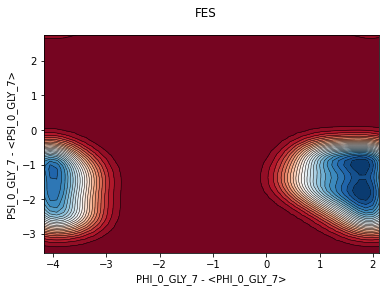

In [11]:
process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/chignolin/enhanced_sampling/PHI_0_GLY_7_PSI_0_GLY_7_structure1_repeat_0', xlabel='PHI_0_GLY_7 - <PHI_0_GLY_7>', ylabel='PSI_0_GLY_7 - <PSI_0_GLY_7>', xcorrection=-1.0328998565673828, ycorrection=-0.4069909453392029)
